In [2]:
import numpy as np, numpy.random as npr, torch.nn as nn, copy, timeit, torch, seaborn as sns
from torch.distributions.bernoulli import Bernoulli 
from tqdm import trange
from samplers import *
from time import time
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import plot, show, legend

Gradient w.r.t. $\theta$:

$$
\nabla_\theta \log p(\theta \mid \sigma, x_{1:n}, y_{1:n}) 
= 
- \sum_{i=1}^n \frac{\left ( \mu_\theta(x_i) - y_i \right ) \, \nabla_\theta \mu_\theta(x_i) }{\sigma^{2k}} + \nabla_\theta \log p_0(\theta) 
$$

#### Set up neural network:

In [3]:
n_in = 1
n_h1 = 5
n_out = 2

nn_model = nn.Sequential(nn.Linear(n_in, n_h1),
                         nn.Tanh(),
                         nn.Linear(n_h1, n_out))

* Total number of parameters:

In [4]:
print(sum(p.numel() for p in nn_model.parameters()))

22


#### Generate some random data:

In [5]:
error_sigma = 2e-1
nobs = 1_000
xtrue = torch.randn(nobs, n_in, requires_grad=True)
xvals = xtrue.data
ytrue = np.zeros((nobs, n_out))
ytrue[:,0] = list(abs(xvals)*np.cos(xvals))
ytrue[:,1] = list(abs(xvals)*np.sin(xvals))
ytrue = 3*torch.from_numpy(ytrue).float() + torch.randn(nobs,2)*error_sigma
criterion = nn.MSELoss()

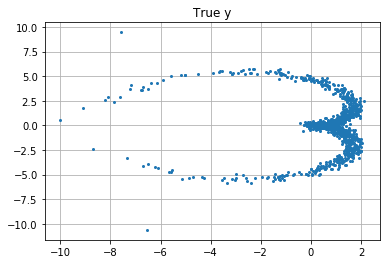

In [5]:
plt.plot(list(ytrue[:,0]), list(ytrue[:,1]), 'o', markersize=2)
plt.grid(True)
plt.title("True y");

### Stochastic gradient optimisation:

In [6]:
init_normal(nn_model)
torch.cat([param.view(-1) for param in nn_model.parameters()])

tensor([-0.7142, -1.3030, -2.3142, -0.8597,  2.3620,  0.6808, -0.2461, -0.8581,
        -0.2178, -0.2631,  0.0102,  0.1934, -0.1932, -0.0305,  0.3382,  0.4067,
        -1.1210,  0.6860, -0.8547, -1.4295, -0.0884,  0.3015],
       grad_fn=<CatBackward>)

In [7]:
Nsteps = 200_000
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(nn_model.parameters(), lr=0.01)
start = time()
for epoch in range(200_000):
    loss = criterion(nn_model(xtrue), ytrue)
    if (epoch+1)%(Nsteps/10) == 0 :
        print("Epoch: %d; loss: %.4f; time: %.1f sec" % (epoch+1, loss.item(), time()-start))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
nn_model_optim = copy.deepcopy(nn_model)
ypred = nn_model(xtrue)
plt.plot(list(ytrue[:,0]), list(ytrue[:,1]), 'o', markersize=2)
plt.plot(list(ypred[:,0]), list(ypred[:,1]), 'o', markersize=2)
plt.grid(True)
plt.title("start");

KeyboardInterrupt: 

### HMC: 

In [6]:
prior_sigma = 1e0
my_model = model(xtrue, ytrue, prior_sigma, 1e0, nn_model)

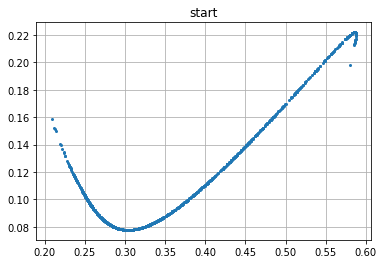

In [7]:
# my_model.init_normal()
my_model.update_grad()
y_initial = my_model.nn_model(my_model.x)
plt.plot(list(y_initial[:,0]), list(y_initial[:,1]), 'o', markersize=2)
plt.grid(True)
plt.title("start");

* Define HMC sampler:

In [10]:
Nsteps = 1000
n_leapfrog = 100
stepsize = 1e-2
hmc = HMC(my_model, Nsteps, stepsize, n_leapfrog)

* Run HMC sampler:

iter    100/1000 after 0.20 min | accept_rate 78.0 percent | MSE loss 1.153
iter    200/1000 after 0.41 min | accept_rate 86.0 percent | MSE loss 1.250
iter    300/1000 after 0.61 min | accept_rate 75.0 percent | MSE loss 1.177
iter    400/1000 after 0.83 min | accept_rate 15.5 percent | MSE loss 1.180
iter    500/1000 after 1.06 min | accept_rate 31.0 percent | MSE loss 1.213
iter    600/1000 after 1.29 min | accept_rate 41.8 percent | MSE loss 1.173
iter    700/1000 after 1.51 min | accept_rate 13.0 percent | MSE loss 1.160
iter    800/1000 after 1.75 min | accept_rate 23.4 percent | MSE loss 1.114
iter    900/1000 after 1.97 min | accept_rate 2.8 percent | MSE loss 1.114
iter   1000/1000 after 2.17 min | accept_rate 12.0 percent | MSE loss 1.173


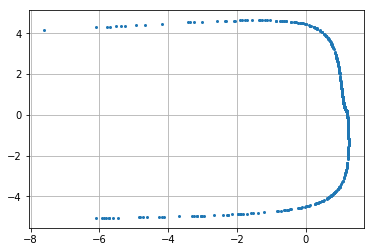

In [11]:
hmc.run()
hmc.plot()

In [16]:
min(hmc.ESS()), max(hmc.ESS())

(121.79627827101643, 1000.0)

### BAOAB:

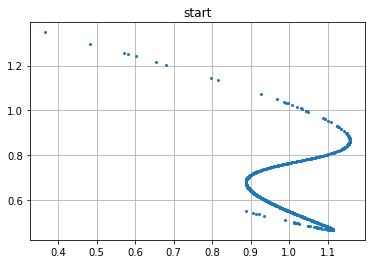

In [12]:
my_model.init_normal()
my_model.update_grad()
y_initial = my_model.nn_model(my_model.x)
plt.plot(list(y_initial[:,0]), list(y_initial[:,1]), 'o', markersize=2)
plt.grid(True)
plt.title("start");

* Define BAOAB sampler:

In [13]:
beta = 1
gamma = 1e0
baoab = BAOAB(my_model, 10**4, 1e-2, beta, gamma)

* Run sampler:

iter   1000/10000 after 0.08 min | accept_rate 5.7 percent | MSE loss 4.375
iter   2000/10000 after 0.15 min | accept_rate 3.4 percent | MSE loss 4.383
iter   3000/10000 after 0.23 min | accept_rate 2.3 percent | MSE loss 4.383
iter   4000/10000 after 0.30 min | accept_rate 1.9 percent | MSE loss 4.375
iter   5000/10000 after 0.38 min | accept_rate 1.6 percent | MSE loss 4.383
iter   6000/10000 after 0.47 min | accept_rate 1.4 percent | MSE loss 4.376
iter   7000/10000 after 0.58 min | accept_rate 1.2 percent | MSE loss 4.382
iter   8000/10000 after 0.67 min | accept_rate 1.1 percent | MSE loss 4.368
iter   9000/10000 after 0.76 min | accept_rate 1.0 percent | MSE loss 4.354
iter  10000/10000 after 0.83 min | accept_rate 0.9 percent | MSE loss 4.354


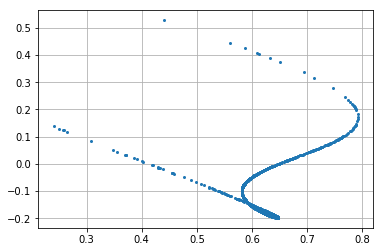

In [14]:
baoab.run()
baoab.plot()

In [15]:
baoab.ESS()

array([ 328.10417348,   26.19898364,  170.3665656 , ...,   16.47885555,
        464.97572063, 2060.01260382])